# Plot Individual ROH
Make nice plots of whole genome, in Karyotype style.

Plot every chromosome: Centromer, and then list of ROH Blocks

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patheffects as pe
import h5py   # For Processing HDF5s

import socket
import os as os
import sys as sys
import multiprocessing as mp

if socket.gethostname() == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket.gethostname() == "midway2-0401.rcc.local" or socket.gethostname() == 'midway2-0402.rcc.local':
    print("Midway jnovmbre partition detected.")
    path = "/project/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./Python3/")  # Since now we are in the Root Directory
from hmm_inference import HMM_Analyze   # Do not move. Should be after sys.path..
#sys.path.append("./Python3/create1000G_Mosaic/")  # Since now we are in the Root Directory
#from createMosaicsMulti import Mosaic_1000G_Multi  # Import the object that can create the Multiruns

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

Midway jnovmbre partition detected.
/project/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


In [15]:
def load_roh(iid, ch, path_folder = "./Empirical/1240k/", prefix_out = "e01/"):
    """Load the ROH Dataframe for Individual iid and 
    Chromosome ch"""
    path = path_folder +  iid + "/chr" + str(ch) + "/" + prefix_out+ "/roh.csv"
    roh_df = pd.read_csv(path)    
    return roh_df

def post_process_roh_df(df, min_cm=4, snp_cm=100, output=False):
    """Post Process ROH Dataframe.
    min_cm: Minimum Length in CentiMorgan
    snp_cm: How many SNPs per CentiMorgan"""
    densities = df["length"] / (df["lengthM"] * 100)
    densities_ok = (densities > snp_cm)
    
    df["SNP_Dens"] = densities
    
    # Filter for SNP Density:
    df = df[densities_ok]
    
    # Filter for Length:
    length_okay = (df["lengthM"] * 100) > min_cm
    
    if output==True:
        print(f"Min SNPs per cM> {snp_cm}: {np.sum(densities_ok)}/{len(densities_ok)}")
        print(f"> {min_cm} cM: {np.sum(length_okay)}/{len(length_okay)}")
    
    df = df[length_okay]
    return df

def load_h5(path, output=True):
        """Load and return the HDF5 File from Path"""
        f = h5py.File(path, "r")  # Load for Sanity Check. See below!
        if output == True:
            print("\nLoaded %i variants" % np.shape(f["calldata/GT"])[0])
            print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
            # print(list(f["calldata"].keys()))
            # print(list(f["variants"].keys()))
            print(f"HDF5 loaded from {path}")
        return f
    
def chrom_length(ch, output=False):
    """Get and retrun length of Chromosome"""
    
    path1000G = "./Data/1000Genomes/HDF5/1240kHDF5/Eur1240chr" + str(ch) + ".hdf5"  # Path of 1000G (without chromosome part)
    f = load_h5(path1000G, output=output)
    rec = np.array(f["variants/MAP"])
    l = np.max(rec)
    return rec, l

In [13]:
def plot_chromosome(ax, l, x_pos, lw=24, df_roh = []):
    """Plot a Chromosome of length l with centromer ctr on ax 
    at x_pos"""
    ln, = ax.plot([x_pos, x_pos], [-0.05,l+0.05], lw = lw, color="lightgray", 
                      solid_capstyle = 'round', zorder=0,
                  path_effects=[pe.Stroke(linewidth=lw+3, foreground='k'), pe.Normal()])
    
    ### Plot the ROH List if given
    if len(df_roh) > 0:
        starts, ends = df_roh["StartM"].values, df_roh["EndM"].values
        
        for i in range(len(df_roh)):
            ax.plot([x_pos, x_pos], [starts[i], ends[i]], lw=lw, color="maroon", 
                    zorder=1, alpha=1.0, solid_capstyle="butt")
            
            #ax.plot([x_pos, x_pos], [-0.01, 0], lw=lw-1, color="black", 
            #        zorder=1, alpha=0.6, solid_capstyle="butt")

In [34]:
### Actual Figure

def plot_roh_individual(iid="MA89", fs=12, figsize=(8,8), save=False, min_cm=4, snp_cm=50):
    """Plot ROH in one ancient Individual"""

    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 2])
    gs.update(hspace=0.1) # set the spacing between axes. 

    ax = plt.subplot(gs[0]) # The left subplot
    ax1 = plt.subplot(gs[1]) # The middle one
    
    df_rohs = []
    for i in range(1,23):
        df_roh = load_roh(iid=iid, ch=i)
        df_roh = post_process_roh_df(df_roh, min_cm=min_cm, snp_cm=snp_cm) # Standad PP
        df_rohs.append(df_roh)
        
    ### Plot the First 11 Chromosomes
    for i in range(1,12):
        rec, l = chrom_length(i)
        plot_chromosome(ax, l, x_pos=(i), df_roh=df_rohs[i-1])  
    
    ### Plot the Second 11 Chromosomes
    for i in range(12,23):
        rec, l = chrom_length(i)
        plot_chromosome(ax1, l, x_pos=(i - 11), df_roh=df_rohs[i-1])

    ### Set the Plot Limits
    ax.set_xlim([0.3, 11.5])
    ax1.set_xlim([0.3, 11.5])

    ax.set_ylim([-0.3,3.3])
    ax1.set_ylim([-0.3, 2.05])

    ### Turn off the Y Axis
    for ax0 in [ax, ax1]:
        ax0.spines['right'].set_visible(False)
        ax0.spines['top'].set_visible(False)
        ax0.spines['bottom'].set_visible(False)
        ax0.yaxis.set_tick_params(labelsize=fs)

    rang = np.arange(1,12)
    ax.set_xticks(rang)
    ax.set_xticklabels(rang, fontsize=fs)

    ax1.set_xticks(rang)
    ax1.set_xticklabels(rang+11, fontsize=fs)
    ax1.set_xticklabels(rang+11, fontsize=fs)

    if save==True:
        savepath="./figures_test/" + iid + "_allchrroh.pdf"
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)

        savepath="./figures_test/" + iid + "_allchrroh.png"
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")
    
    ax.set_title(iid, fontsize=fs)
    plt.show()

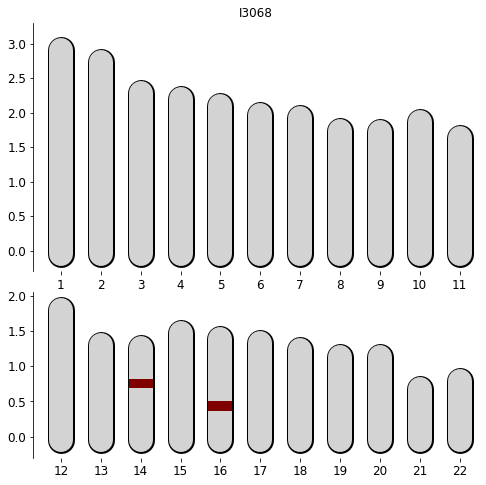

In [37]:
plot_roh_individual(iid="I3068")

# Area 51

In [12]:
load_roh(iid="MA89", ch=3)

,Start,End,StartM,EndM,length,lengthM,iid,ch
0,8763,9029,0.407479,0.419341,266,0.011862,MA89,3
1,28160,42012,1.066410,1.469917,13852,0.403507,MA89,3
2,49506,50020,1.714682,1.728582,514,0.013900,MA89,3
